## Importações e configurações do ambiente

In [43]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
# import scipy.stats as stats
# from sklearn.linear_model import LinearRegression
# %config InlineBackend.figure_format = 'retina'

## Sintése do *dataset*

Para ilustrar e motivar o uso da F-statistic, irei criar um conjunto de dados completamente aleatório - composto por $n$ variáveis preditoras sem nenhuma relação com a variável de resposta $y$

In [3]:
num_pred = 50
num_obs  = 30
data = np.random.uniform(0,1,size=(num_obs, num_pred))

In [5]:
# Criando o DataFrame
id_preds = [f"X{i+1}" for i in range(num_pred)]
df = pd.DataFrame(data, columns=id_preds)

In [6]:
# Exibindo o DataFrame
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50
0,0.089494,0.758060,0.497381,0.383920,0.648651,0.542690,0.812092,0.969206,0.565218,0.635257,...,0.742090,0.820945,0.824590,0.104221,0.214655,0.336745,0.542613,0.314413,0.002859,0.147290
1,0.188361,0.139266,0.616086,0.417605,0.583822,0.668268,0.386082,0.394082,0.917372,0.707414,...,0.964284,0.650779,0.604109,0.640326,0.044638,0.622314,0.491692,0.660935,0.247670,0.636741
2,0.976630,0.390921,0.962636,0.830990,0.679565,0.390565,0.261783,0.220890,0.893784,0.722065,...,0.665469,0.502688,0.000421,0.019009,0.880058,0.635375,0.588703,0.801391,0.955885,0.890316
3,0.040198,0.837987,0.108247,0.229688,0.299488,0.341206,0.066156,0.894527,0.474253,0.139841,...,0.832269,0.413858,0.345561,0.326480,0.941679,0.799340,0.829021,0.303718,0.093353,0.139503
4,0.736330,0.347115,0.238982,0.706778,0.392491,0.563226,0.217653,0.331673,0.435708,0.674490,...,0.807031,0.658394,0.353490,0.831781,0.894284,0.554529,0.797461,0.572630,0.030545,0.386998


Agora irei criar uma coluna com os dados da variável dependente, $y$

In [10]:
df['y'] = np.random.normal(0,1,num_obs)

O `dataframe` resultante possui 50 colunas representando as variáveis independentes e uma coluna representando a resposta. Note que, por construção, não há nenhuma relação entre $X$ e $y$. Isto é, esperamos que, na média, a correlação entre as variáveis independentes (preditores) e a variável independente (resposta) seja próxima de zero.

Analisando as estatísticas descritivas da correlação entre cada variável independente $X$ com relação a $y$ 

In [23]:
df.corr()['y'].describe()

count    51.000000
mean     -0.015734
std       0.237656
min      -0.482407
25%      -0.146377
50%      -0.023708
75%       0.099966
max       1.000000
Name: y, dtype: float64

> O valor máximo está associado a autocorrelação de $y$

Vamos selecionar as variáveis com a maior correlação e estudá-las separadamente

In [29]:
falsas_correlacoes = list(df.corr()['y'].sort_values(ascending=False).head(5).index)

In [32]:
falsas_correlacoes.remove('y')

## Visualizando a relação

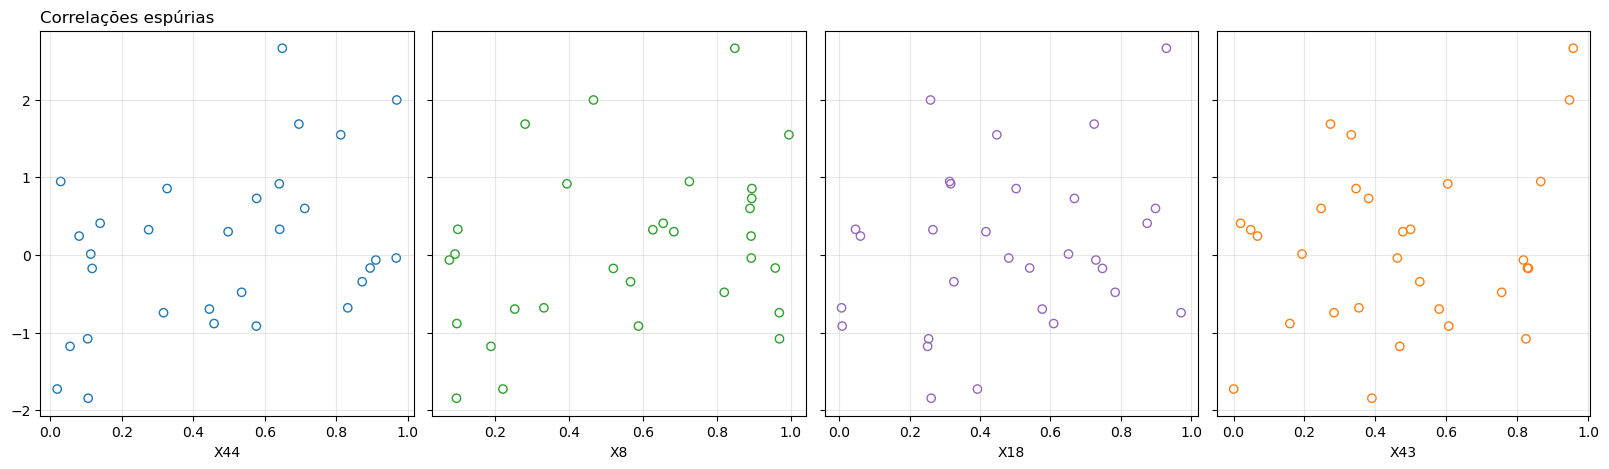

In [41]:
fig, axs = plt.subplots(1,len(falsas_correlacoes),figsize=(20,5),sharey=True, gridspec_kw={'wspace':0.05})
cores = ['tab:blue','tab:green', 'tab:purple', 'tab:orange']
for var_ind, ax, cor in zip(falsas_correlacoes,axs,cores):
    ax.scatter(df[var_ind],df['y'], edgecolor=cor, color='None')
    ax.set_xlabel(var_ind)
    ax.grid(alpha=0.3)

axs[0].set_title('Correlações espúrias',loc='left')
plt.show()

## Regressão linear simples

In [44]:
estatisticas_estimadores_consolidado = []
estatisticas_modelo_consolidado = []

for preditor in df[falsas_correlacoes]:
    
    X_vies = sm.add_constant(df[preditor])  # Adicionando intercepto
    modelo = sm.OLS(df['y'], X_vies).fit()
    
    estatisticas_estimadores = {
        'Estimador': preditor,
        'Coeficiente': modelo.params[preditor],
        'SE': modelo.bse[preditor],
        't-statistic': modelo.tvalues[preditor],
        'p-value': modelo.pvalues[preditor]}
     
    estatisticas_modelo = {   
        'Preditor': preditor,
        'R2' : modelo.rsquared,
        'RSE': np.sqrt(modelo.mse_resid)}
    
    estatisticas_estimadores_consolidado.append(estatisticas_estimadores)
    estatisticas_modelo_consolidado.append(estatisticas_modelo)

### Análise dos coeficientes estimados

In [45]:
# Dataframe com as estatísticas dos estimadores
estimadores_regressao_simples = pd.DataFrame(estatisticas_estimadores_consolidado)
estimadores_regressao_simples.set_index('Estimador',inplace=True)

In [46]:
estimadores_regressao_simples

,Coeficiente,SE,t-statistic,p-value
Estimador,,,,
X44,1.316674,0.576476,2.284005,0.030157
X8,1.059861,0.582293,1.820151,0.079442
X18,0.938652,0.685995,1.368307,0.182096
X43,0.859870,0.677559,1.269071,0.214864


Usando como critério os *p-values*, somente a variável $X_{44}$ atingiu o nível de significância estatística mínima para ser considerada relavante para o modelo

### Análise dos modelos na regressão simples

In [47]:
# Dataframe com as métricas de desempenho dos modelos
desempenho_modelos_simples = pd.DataFrame(estatisticas_modelo_consolidado)
desempenho_modelos_simples.set_index('Preditor',inplace=True)

In [48]:
desempenho_modelos_simples

,R2,RSE
Preditor,,
X44,0.157050,0.988171
X8,0.105801,1.017767
X18,0.062676,1.042021
X43,0.054391,1.046616


De acordo com a tabela acima, $X_{44}$ é responsável por explicar 15% da variabilidade da resposta. A análise para as demais variáveis será ignorada uma vez que já descartamos seu impacto explicativo no modelo pela análise dos *p-values*

## Regressão linear multivariada

Agora vamos performar uma regressão multivariada e analisar novamente as métricas e estatísticas discutidas acima

In [51]:
X_vies = sm.add_constant(df.iloc[:,:-1])
modelo_multivariavel = sm.OLS(df['y'], X_vies).fit()

# Extraindo estatísticas dos coeficientes
estimadores_regressao_multivariada = pd.DataFrame({
    'Coeficiente': modelo_multivariavel.params,
    'SE': modelo_multivariavel.bse,
    't-statistic': modelo_multivariavel.tvalues,
    'p-value': modelo_multivariavel.pvalues
})

C:\Users\gabri\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1718: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


In [52]:
estimadores_regressao_multivariada

,Coeficiente,SE,t-statistic,p-value
const,0.142443,inf,0.0,NaN
X1,-1.615262,inf,-0.0,NaN
X2,-0.176426,inf,-0.0,NaN
X3,0.018587,inf,0.0,NaN
X4,-0.179620,inf,-0.0,NaN
X5,-0.403897,inf,-0.0,NaN
X6,0.112561,inf,0.0,NaN
X7,-0.025678,inf,-0.0,NaN
X8,1.185589,inf,0.0,NaN
X9,0.228598,inf,0.0,NaN
